# Bike City Share

We will work on the data posted on the site [NYC and Bike City Share, LCC and Jersey City Share, LCC](https://www.citibikenyc.com/system-data). The data shall include details of urban bike rentals (start and end date, destination, geographical data, etc.).

## Preparation
Let's first download the data corresponding to one month (the most recent)

In [1]:
import pandas as pd
import zipfile
import os


data_folder = 'data'
data_file_sample = '201911-citibike-tripdata'
data_path = os.path.join(os.getcwd(), data_folder, data_file_sample+'.csv.zip')
zf = zipfile.ZipFile(data_path)
data_sample = pd.read_csv(zf.open(data_file_sample+'.csv'), parse_dates=['starttime', 'stoptime'])

## A glance at the data
Let's check at the beginning what the general data structure looks like

In [5]:
data_sample.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,527,2019-10-01 00:00:05.618,2019-10-01 00:08:52.943,3746,6 Ave & Broome St,40.724308,-74.004730,223,W 13 St & 7 Ave,40.737815,-73.999947,41750,Subscriber,1993,1
1,174,2019-10-01 00:00:15.875,2019-10-01 00:03:10.168,3301,Columbus Ave & W 95 St,40.791956,-73.968087,3283,W 89 St & Columbus Ave,40.788221,-73.970416,18264,Subscriber,1992,1
2,759,2019-10-01 00:00:19.824,2019-10-01 00:12:59.707,161,LaGuardia Pl & W 3 St,40.729170,-73.998102,174,E 25 St & 1 Ave,40.738177,-73.977387,25525,Subscriber,1995,1
3,615,2019-10-01 00:00:21.068,2019-10-01 00:10:36.679,254,W 11 St & 6 Ave,40.735324,-73.998004,477,W 41 St & 8 Ave,40.756405,-73.990026,30186,Subscriber,1992,1
4,761,2019-10-01 00:00:26.380,2019-10-01 00:13:08.313,161,LaGuardia Pl & W 3 St,40.729170,-73.998102,174,E 25 St & 1 Ave,40.738177,-73.977387,25597,Subscriber,1992,1


In [6]:
data_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2092573 entries, 0 to 2092572
Data columns (total 15 columns):
tripduration               int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id           int64
start station name         object
start station latitude     float64
start station longitude    float64
end station id             int64
end station name           object
end station latitude       float64
end station longitude      float64
bikeid                     int64
usertype                   object
birth year                 int64
gender                     int64
dtypes: datetime64[ns](2), float64(4), int64(6), object(3)
memory usage: 239.5+ MB


We have fifteen attributes, three of which are of a categorical type (`start station name`, `end station name`, `usertype`), two are of `datatime64` type (`starttime`, `stoptime`) and the rest of which are numerical.

We still have to answer the question what type of numerical data are - whether they can be treated as continuous or as a set of discrete values (for example, we can predict that the station identifiers will be considered as discrete).

In [7]:
data_sample.nunique()

tripduration                 10837
starttime                  2091108
stoptime                   2091139
start station id               837
start station name             837
start station latitude         837
start station longitude        837
end station id                 848
end station name               848
end station latitude           848
end station longitude          848
bikeid                       15872
usertype                         2
birth year                     106
gender                           3
dtype: int64



In the case of real-life data, one of the most important problems is the missing observations.

In [8]:
data_sample.isnull().any()

tripduration               False
starttime                  False
stoptime                   False
start station id           False
start station name         False
start station latitude     False
start station longitude    False
end station id             False
end station name           False
end station latitude       False
end station longitude      False
bikeid                     False
usertype                   False
birth year                 False
gender                     False
dtype: bool

There is no problem with this particular sample. Nevertheless, care should be taken, as missing observations may appear in data from other periods - you have to be prepared for such a possibility. We will address this issue at a later stage.

In the case under consideration, the duration of the trip (`tripduration` - expressed in seconds) is a categorical, continuous variable. Visualization of this type of data is convenient with the use of histogram

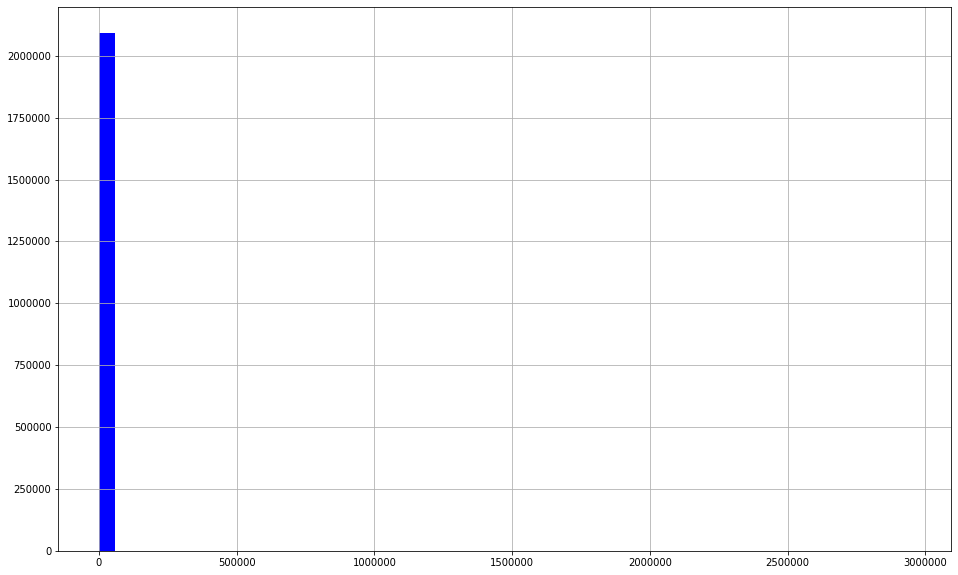

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

data_sample['tripduration'].hist(bins=50, figsize=(16,10), color='blue')
plt.show()

Most of the values do not exceed one good (86400 seconds). However, there are extremely large observations

In [10]:
data_sample[['tripduration']].sort_values(by='tripduration', ascending=False)[:20]

,tripduration
42479,2946638
132013,2616700
383859,2493265
300921,2417904
86193,2055354
466589,1962511
605076,1962000
62979,1948100
825692,1790337
691709,1710328


The longest journey lasted over a month! ($2946638 \ sec \approx 34 \ days$). This may mean that the bike has not been parked properly or there is an error in the time registration system. In any case, such observations obscure the overall distribution of this feature.

In order to illustrate the distribution of travel time without taking into account outliers, it is possible to use the logarithm of a given feature

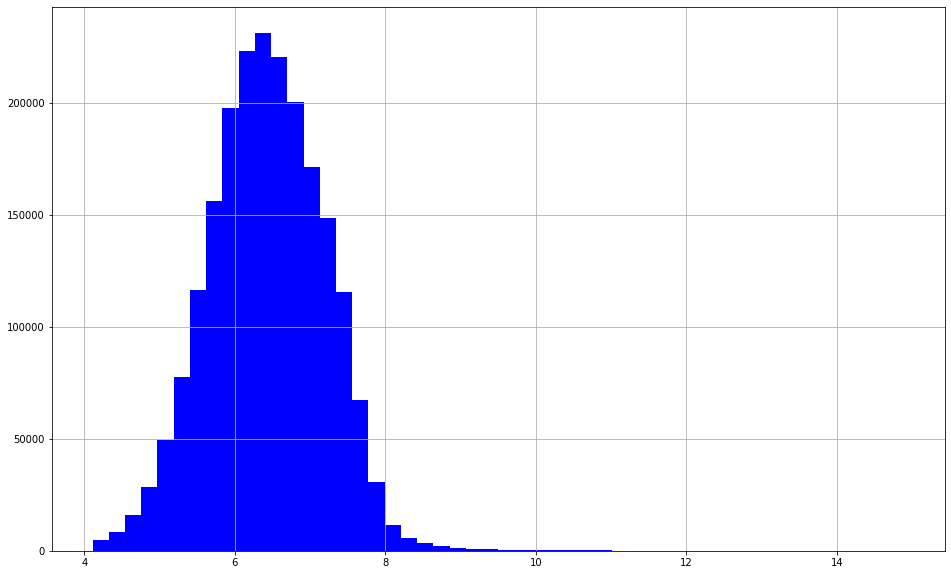

In [11]:
import numpy as np

np.log(data_sample['tripduration']).hist(bins=50, figsize=(16,10), color='blue')
plt.show()

For latitude and longitude, let's first note that the station name is clearly associated with its latitude, longitude and ID. Additionaly, end locations contain more unique names - let's see first that they contain all start locations

In [12]:
set(data_sample['end station id'].unique()).issubset(set(data_sample['end station id'].unique()))

True

In [13]:
data_sample[['end station id', 'end station name', 'end station latitude', 'end station longitude']].drop_duplicates()

,end station id,end station name,end station latitude,end station longitude
0,223,W 13 St & 7 Ave,40.737815,-73.999947
1,3283,W 89 St & Columbus Ave,40.788221,-73.970416
2,174,E 25 St & 1 Ave,40.738177,-73.977387
3,477,W 41 St & 8 Ave,40.756405,-73.990026
7,3592,Crescent St & Broadway,40.763359,-73.928647
...,...,...,...,...
1958781,3827,Halsey St & Broadway,40.685650,-73.915640
1960912,3890,Grove St & Broadway,40.690470,-73.923511
2043185,3828,Eldert St & Bushwick Ave,40.686520,-73.913210
2081854,3868,Knickerbocker Ave & Halsey St,40.693000,-73.908240


Therefore, we can significantly reduce the amount of space needed in the memory by building a dictionary - its key will be the station identifier, and the value will be another dictionary that will store information about the station name and its geographical location

In [14]:
dict_data = data_sample[['end station id','end station name','end station latitude','end station longitude']].drop_duplicates()
dict_data.set_index('end station id', drop=True, inplace=True)
data_sample_station_dict = dict_data.to_dict(orient='index')
data_sample_station_dict[3833]

{'end station name': 'Madison St & Evergreen Ave',
 'end station latitude': 40.69122,
 'end station longitude': -73.91693000000001}

Geographic data is conveniently illustrated spatially

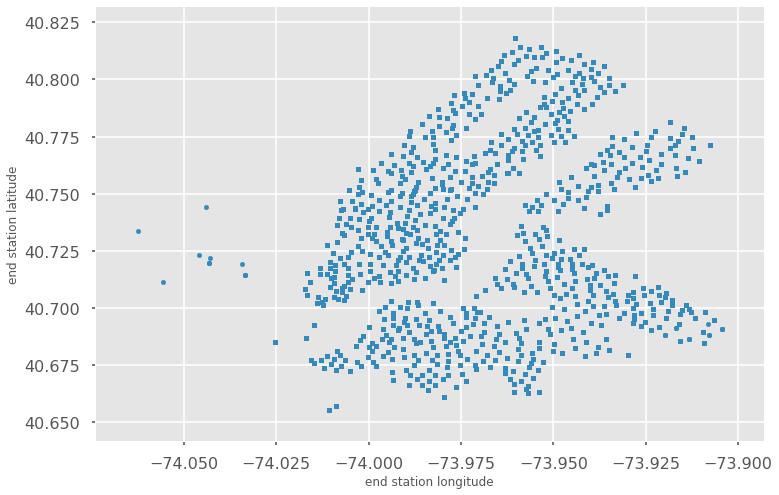

In [15]:
import matplotlib.style as style
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

data_sample.plot(kind='scatter', x='end station longitude', y='end station latitude', alpha=1, figsize=(12,8))

The frequency of visits to a given station can be visualized by the appropriate marker shade

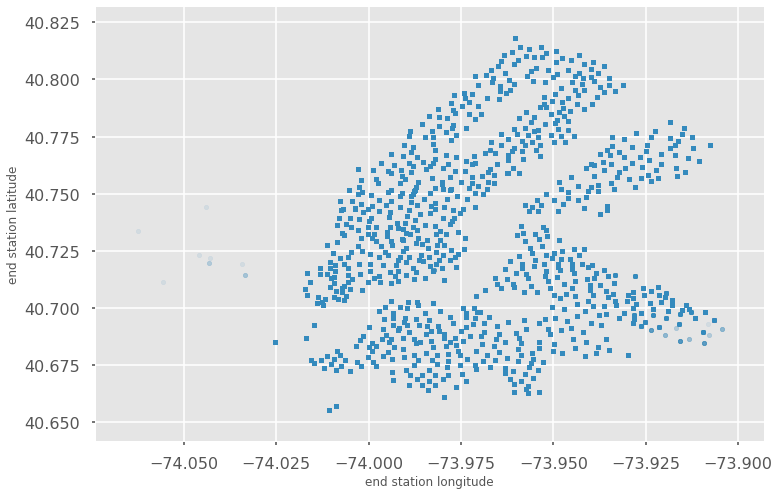

In [16]:
data_sample.plot(kind='scatter', x='end station longitude', y='end station latitude', alpha=0.1, figsize=(12,8))

Clustered stations are definitely more frequently visited than those at the ends

Interesting information that we can get from these is the frequency of visiting the station - both as the starting and ending point of the journey

In [17]:
import numpy as np

data_sample['end_station_freq'] = data_sample['end station id']
data_sample['end_station_freq'].groupby(data_sample['end station id']).transform('count')

data_sample['start_station_freq'] = data_sample['start station id']
data_sample['start_station_freq'].groupby(data_sample['start station id']).transform('count')

data_sample.head(10)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,end_station_freq,start_station_freq
0,527,2019-10-01 00:00:05.618,2019-10-01 00:08:52.943,3746,6 Ave & Broome St,40.724308,-74.004730,223,W 13 St & 7 Ave,40.737815,-73.999947,41750,Subscriber,1993,1,223,3746
1,174,2019-10-01 00:00:15.875,2019-10-01 00:03:10.168,3301,Columbus Ave & W 95 St,40.791956,-73.968087,3283,W 89 St & Columbus Ave,40.788221,-73.970416,18264,Subscriber,1992,1,3283,3301
2,759,2019-10-01 00:00:19.824,2019-10-01 00:12:59.707,161,LaGuardia Pl & W 3 St,40.729170,-73.998102,174,E 25 St & 1 Ave,40.738177,-73.977387,25525,Subscriber,1995,1,174,161
3,615,2019-10-01 00:00:21.068,2019-10-01 00:10:36.679,254,W 11 St & 6 Ave,40.735324,-73.998004,477,W 41 St & 8 Ave,40.756405,-73.990026,30186,Subscriber,1992,1,477,254
4,761,2019-10-01 00:00:26.380,2019-10-01 00:13:08.313,161,LaGuardia Pl & W 3 St,40.729170,-73.998102,174,E 25 St & 1 Ave,40.738177,-73.977387,25597,Subscriber,1992,1,174,161
5,750,2019-10-01 00:00:37.906,2019-10-01 00:13:08.413,161,LaGuardia Pl & W 3 St,40.729170,-73.998102,174,E 25 St & 1 Ave,40.738177,-73.977387,21757,Subscriber,1995,1,174,161
6,454,2019-10-01 00:01:18.448,2019-10-01 00:08:52.817,525,W 34 St & 11 Ave,40.755942,-74.002116,477,W 41 St & 8 Ave,40.756405,-73.990026,41079,Subscriber,1994,1,477,525
7,416,2019-10-01 00:01:21.455,2019-10-01 00:08:17.742,3616,Steinway St & 28 Ave,40.765625,-73.913669,3592,Crescent St & Broadway,40.763359,-73.928647,33413,Subscriber,1988,1,3592,3616
8,118,2019-10-01 00:02:00.775,2019-10-01 00:03:59.561,3306,10 St & 7 Ave,40.666208,-73.981999,3310,14 St & 7 Ave,40.663779,-73.983968,38925,Subscriber,1976,1,3310,3306
9,1301,2019-10-01 00:02:06.301,2019-10-01 00:23:47.946,3687,E 33 St & 1 Ave,40.743227,-73.974498,259,South St & Whitehall St,40.701221,-74.012342,41376,Subscriber,1963,1,259,3687


Let's see which stations are the most common destinations

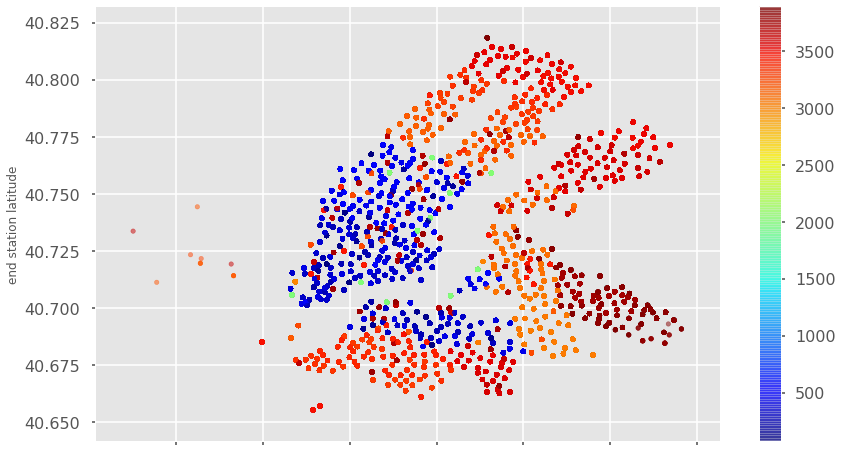

In [18]:
data_sample.plot(kind='scatter', x='end station longitude', y='end station latitude', alpha=0.5, 
                 c=data_sample['end_station_freq'], figsize=(14,8), cmap=plt.get_cmap('jet'), colorbar=True)

An analogous graph for the starting places

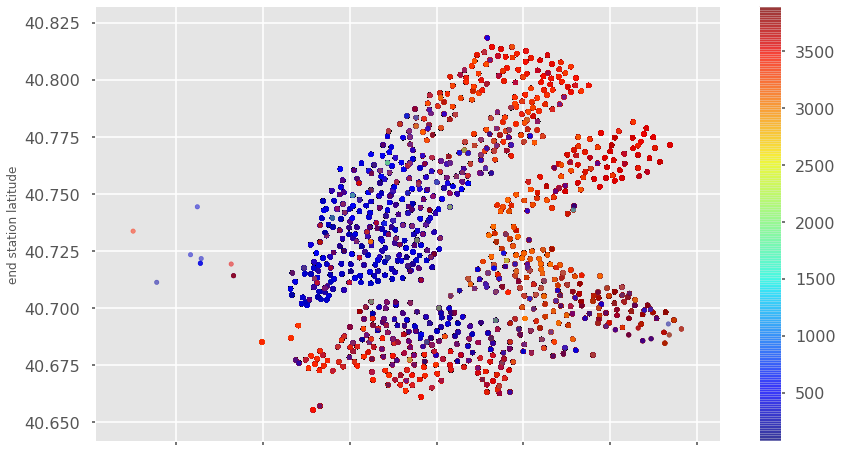

In [19]:
data_sample.plot(kind='scatter', x='end station longitude', y='end station latitude', alpha=0.5, 
                 c=data_sample['start_station_freq'], figsize=(14,8), cmap=plt.get_cmap('jet'), colorbar=True)

Let's see what it looks like against the background of the New York map - we'll use the `geopandas` package for this purpose

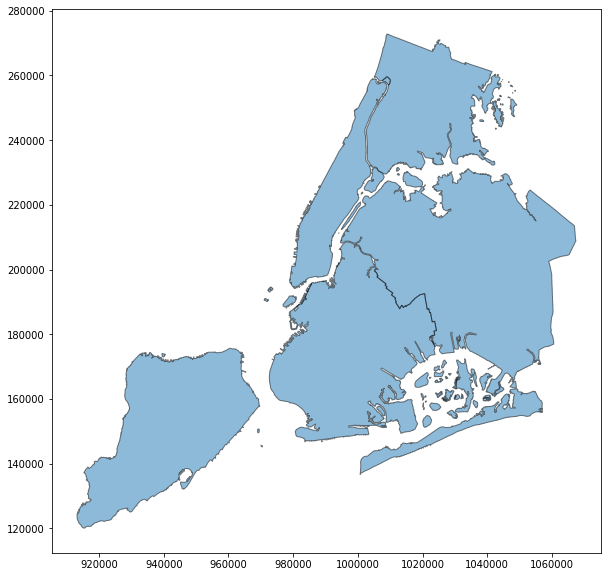

In [5]:
import geopandas
import contextily as ctx

df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

On the example of the analyzed month, it can be seen that stations in the central part are much less frequently visited than others

## Fetch the entire dataset

In [2]:
from os import listdir
from os.path import isfile, join

data_files = [file for file in listdir(join(os.getcwd(), data_folder)) if isfile(join(os.getcwd(),data_folder,file))]
column_names = ['TripDuration', 'StartTime','StopTime','StartStationId',
               'StartStationName','StartStationLatitude', 'StartStationLongitude',
               'EndStationId','EndStationName','EndStationLatitude',
               'EndStationLongitude','BikeId','UserType','BirthYear','Gender'] #Unification of column names
column_dtypes = {'TripDuration'}
files = []
for file in data_files:
    zf = zipfile.ZipFile(join(os.getcwd(), data_folder, file))
    files.append(pd.read_csv(zf.open(file[:-4]), header=None, parse_dates=[1, 2], 
                             names=column_names, skiprows=1))

Concatenate into one data frame

In [3]:
data = pd.concat(files)
data.reset_index(drop=True, inplace=True)

Let's check if the data is in the same format as the sample csv file

In [6]:
data.head(10)

,TripDuration,StartTime,StopTime,StartStationId,StartStationName,StartStationLatitude,StartStationLongitude,EndStationId,EndStationName,EndStationLatitude,EndStationLongitude,BikeId,UserType,BirthYear,Gender
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226.0,W 82 St & Central Park West,40.782750,-73.971370,3165.0,Central Park West & W 72 St,40.775794,-73.976206,25542,Subscriber,1965.0,2
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263.0,Cooper Square & E 7 St,40.729236,-73.990868,498.0,Broadway & W 32 St,40.748549,-73.988084,21136,Subscriber,1987.0,2
2,648,2017-01-01 00:00:57,2017-01-01 00:11:46,3143.0,5 Ave & E 78 St,40.776829,-73.963888,3152.0,3 Ave & E 71 St,40.768737,-73.961199,18147,Customer,NaN,0
3,631,2017-01-01 00:01:10,2017-01-01 00:11:42,3143.0,5 Ave & E 78 St,40.776829,-73.963888,3152.0,3 Ave & E 71 St,40.768737,-73.961199,21211,Customer,NaN,0
4,621,2017-01-01 00:01:25,2017-01-01 00:11:47,3143.0,5 Ave & E 78 St,40.776829,-73.963888,3152.0,3 Ave & E 71 St,40.768737,-73.961199,26819,Customer,NaN,0
5,666,2017-01-01 00:01:51,2017-01-01 00:12:57,3163.0,Central Park West & W 68 St,40.773407,-73.977825,3163.0,Central Park West & W 68 St,40.773407,-73.977825,16050,Subscriber,2000.0,1
6,559,2017-01-01 00:05:00,2017-01-01 00:14:20,499.0,Broadway & W 60 St,40.769155,-73.981918,479.0,9 Ave & W 45 St,40.760193,-73.991255,27294,Subscriber,1973.0,1
7,826,2017-01-01 00:05:37,2017-01-01 00:19:24,362.0,Broadway & W 37 St,40.751726,-73.987535,445.0,E 10 St & Avenue A,40.727408,-73.981420,23288,Subscriber,1977.0,2
8,255,2017-01-01 00:05:47,2017-01-01 00:10:02,430.0,York St & Jay St,40.701485,-73.986569,242.0,Carlton Ave & Flushing Ave,40.697787,-73.973736,25041,Subscriber,1989.0,1
9,634,2017-01-01 00:07:34,2017-01-01 00:18:08,3165.0,Central Park West & W 72 St,40.775794,-73.976206,3164.0,Columbus Ave & W 72 St,40.777057,-73.978985,16311,Subscriber,1980.0,1


At first glance, they have the same structure

In [23]:
print(data_sample.info()==data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2092573 entries, 0 to 2092572
Data columns (total 17 columns):
tripduration               int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id           int64
start station name         object
start station latitude     float64
start station longitude    float64
end station id             int64
end station name           object
end station latitude       float64
end station longitude      float64
bikeid                     int64
usertype                   object
birth year                 int64
gender                     int64
end_station_freq           int64
start_station_freq         int64
dtypes: datetime64[ns](2), float64(4), int64(8), object(3)
memory usage: 271.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27432542 entries, 0 to 27432541
Data columns (total 15 columns):
TripDuration             int64
StartTime                datetime64[ns]
StopTime                 dat

The data types also agree (note that the ID of the start and end stations are floating point, not integer)

We can also examine missing observations

In [24]:
data.isnull().any()

TripDuration             False
StartTime                False
StopTime                 False
StartStationId            True
StartStationName          True
StartStationLatitude     False
StartStationLongitude    False
EndStationId              True
EndStationName            True
EndStationLatitude       False
EndStationLongitude      False
BikeId                   False
UserType                  True
BirthYear                 True
Gender                   False
dtype: bool

In this case, there are missing data that we will deal with soon.

If the deficiencies constituted the majority in a given column, we could resign from analyzing such an attribute

In [25]:
data.isnull().sum(axis=0)

TripDuration                  0
StartTime                     0
StopTime                      0
StartStationId              878
StartStationName            878
StartStationLatitude          0
StartStationLongitude         0
EndStationId                878
EndStationName              878
EndStationLatitude            0
EndStationLongitude           0
BikeId                        0
UserType                   8329
BirthYear                760154
Gender                        0
dtype: int64

In [26]:
data.isnull().sum(axis=0)/data.shape[0]

TripDuration             0.000000
StartTime                0.000000
StopTime                 0.000000
StartStationId           0.000032
StartStationName         0.000032
StartStationLatitude     0.000000
StartStationLongitude    0.000000
EndStationId             0.000032
EndStationName           0.000032
EndStationLatitude       0.000000
EndStationLongitude      0.000000
BikeId                   0.000000
UserType                 0.000304
BirthYear                0.027710
Gender                   0.000000
dtype: float64

For visualizing missing data, use the ```missingno``` package

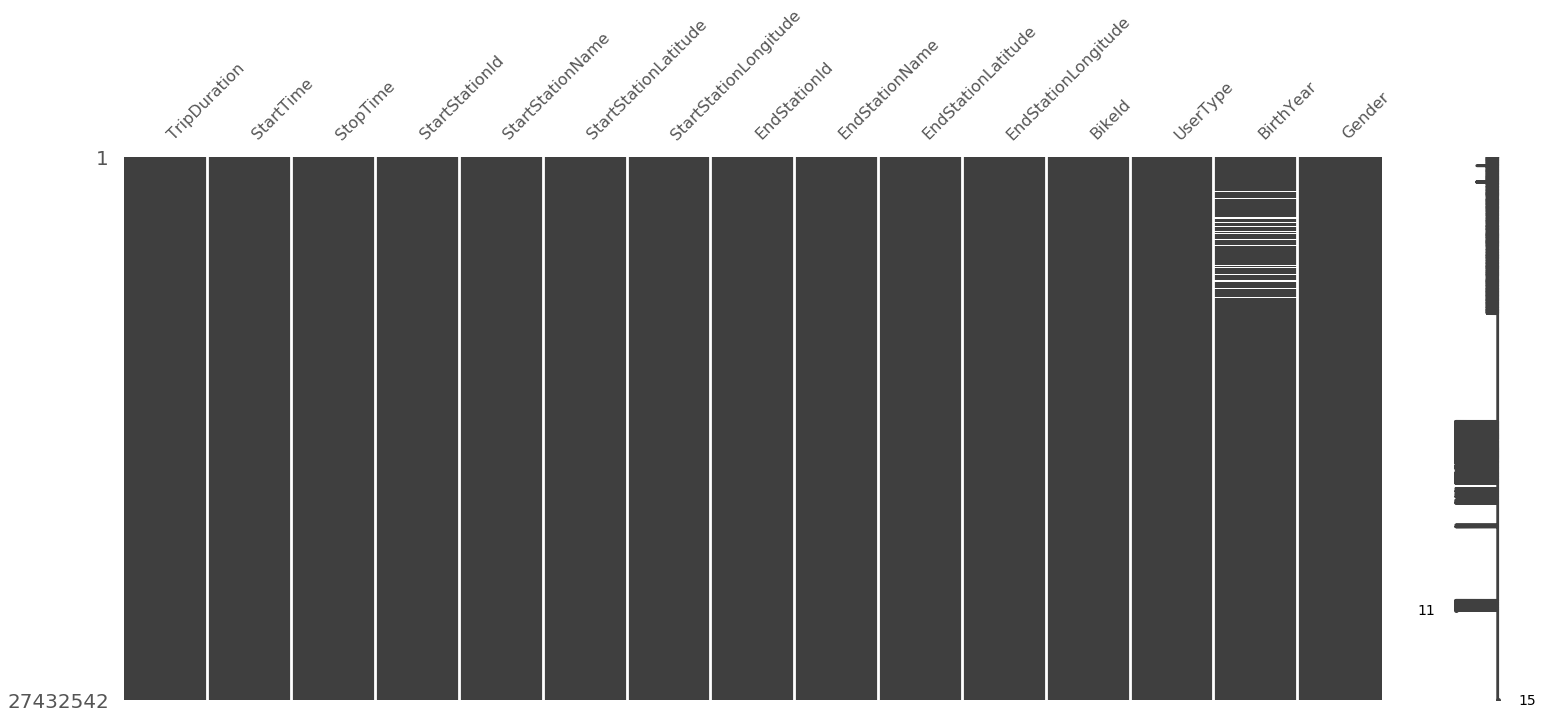

In [27]:
import missingno as msno

msno.matrix(data)

We see that the deficiencies mainly concern the date of birth

## Analyzes

The data comes from three years - we have observations from over 35 months. We can answer many interesting questions by analyzing such a time series knowing the characteristics in short time horizons (e.g. monthly). To do this, it is convenient to break the date of each trip into year, month and day (we assume that the date of travel to the start date)

In [5]:
data = data.assign(
    Year = data.StartTime.dt.year,
    Month = data.StartTime.dt.month,
    Day = data.StartTime.dt.day
)
data.head()

,TripDuration,StartTime,StopTime,StartStationId,StartStationName,StartStationLatitude,StartStationLongitude,EndStationId,EndStationName,EndStationLatitude,EndStationLongitude,BikeId,UserType,BirthYear,Gender,Year,Month,Day
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226.0,W 82 St & Central Park West,40.782750,-73.971370,3165.0,Central Park West & W 72 St,40.775794,-73.976206,25542,Subscriber,1965.0,2,2017,1,1
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263.0,Cooper Square & E 7 St,40.729236,-73.990868,498.0,Broadway & W 32 St,40.748549,-73.988084,21136,Subscriber,1987.0,2,2017,1,1
2,648,2017-01-01 00:00:57,2017-01-01 00:11:46,3143.0,5 Ave & E 78 St,40.776829,-73.963888,3152.0,3 Ave & E 71 St,40.768737,-73.961199,18147,Customer,NaN,0,2017,1,1
3,631,2017-01-01 00:01:10,2017-01-01 00:11:42,3143.0,5 Ave & E 78 St,40.776829,-73.963888,3152.0,3 Ave & E 71 St,40.768737,-73.961199,21211,Customer,NaN,0,2017,1,1
4,621,2017-01-01 00:01:25,2017-01-01 00:11:47,3143.0,5 Ave & E 78 St,40.776829,-73.963888,3152.0,3 Ave & E 71 St,40.768737,-73.961199,26819,Customer,NaN,0,2017,1,1


We can now see, for example, how the average journey distance changes depending on the month over three different years. For further analysis, we will create a grouped data frame (relative to year, month and day)

In [5]:
data_grouped = data.groupby(['Year','Month','Day'])

Let's see how the average journey length looks over the entire period considered

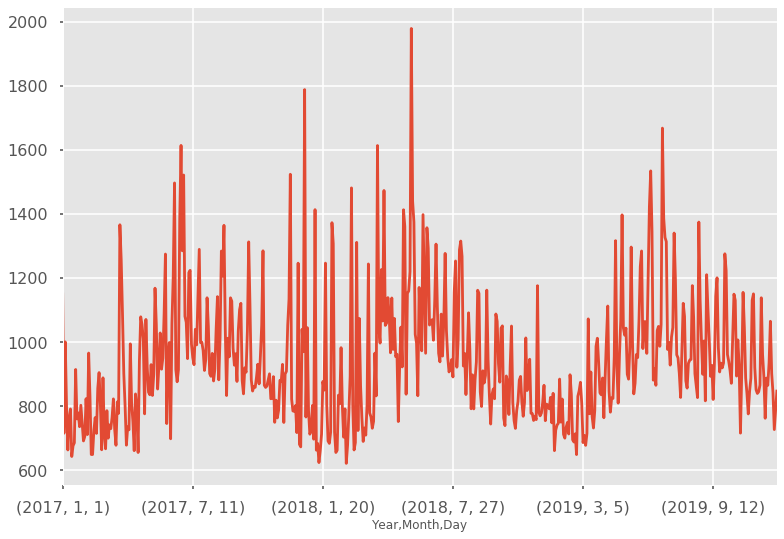

In [33]:
data_grouped.mean()['TripDuration'].plot()

Apart from the high data noise, it can be seen that the general trend is periodic - in the winter season the average time of using city bikes is clearly lower compared to the summer season.

Of course, the mentioned noise comes from outliers - let's see what they look like in the background

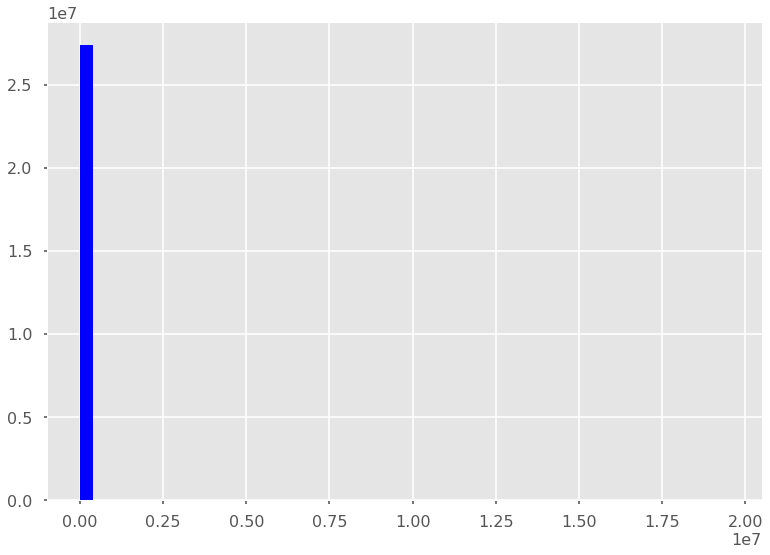

In [58]:
data['TripDuration'].hist(bins=50, color='blue')

Regularized hisogram

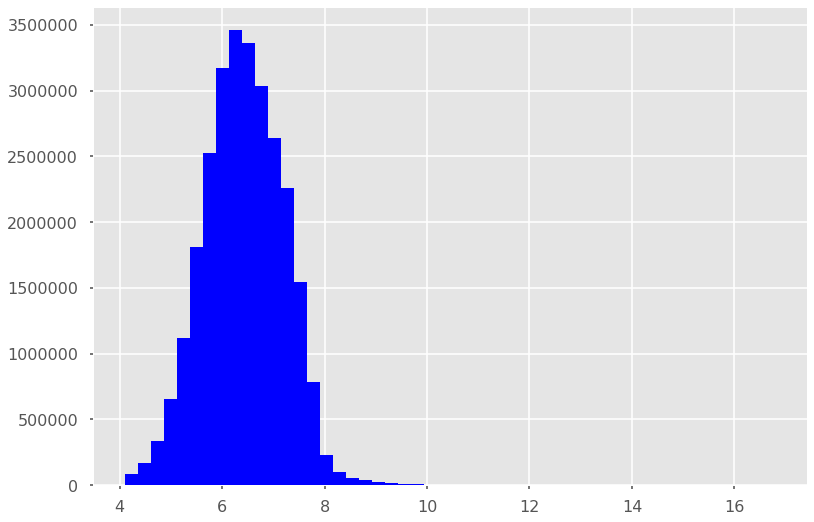

In [60]:
np.log(data['TripDuration']).hist(bins=50, color='blue')

Histograms resemble what we have noticed for data corresponding to one month. It is also convenient to use a box chart to analyze outsiders

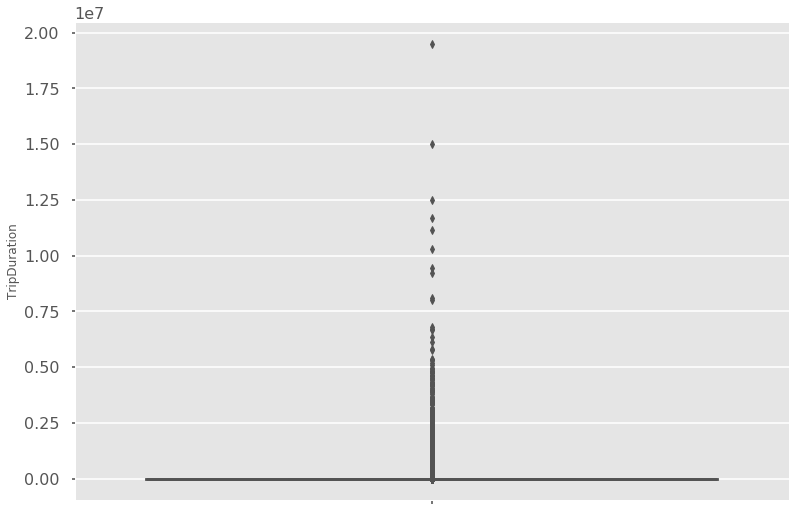

In [61]:
import seaborn as sns

sns.boxplot(data=data, y='TripDuration', orient='v')

Of course, values of $0.25 * 10 ^ 7$ seconds and higher (i.e. month and more) are unrealistic - it can be concluded that their source lies in the errors of the system of recording the time of renting a bike or its incorrect putting away


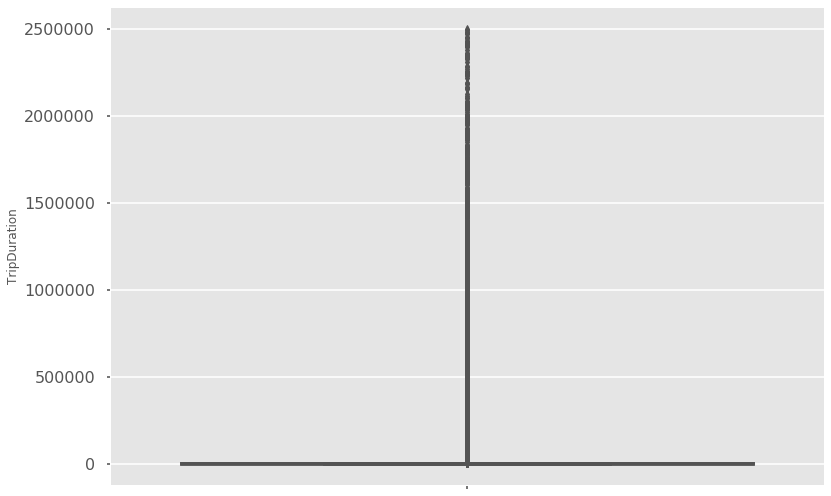

In [62]:
sns.boxplot(data=data.loc[data.TripDuration<0.25*10**7], y='TripDuration', orient='v')

We can see that we still have a lot of outliers, and the box graph is visually reduced. Let's try to reduce this threshold yet

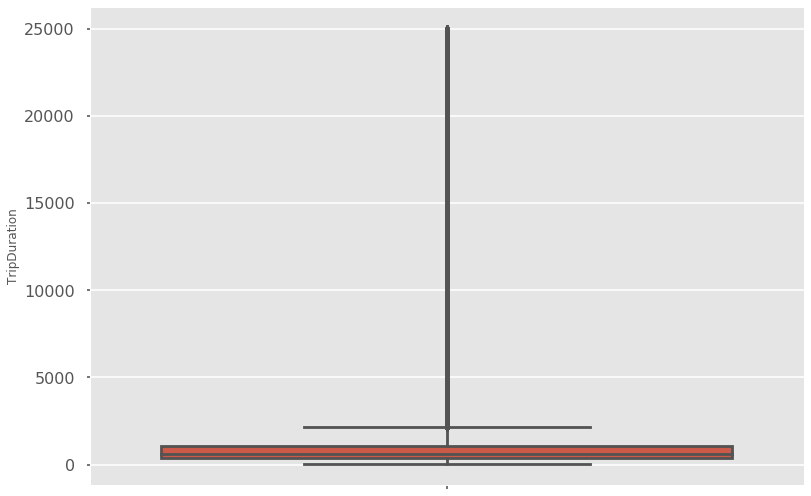

In [63]:
sns.boxplot(data=data.loc[data.TripDuration<0.25*10**5], y='TripDuration', orient='v')

Let's try to check what the average for such reduced data looks like


In [7]:
data_grouped_reduced = data.loc[data.TripDuration<0.25*10**5].groupby(['Year','Month','Day'])

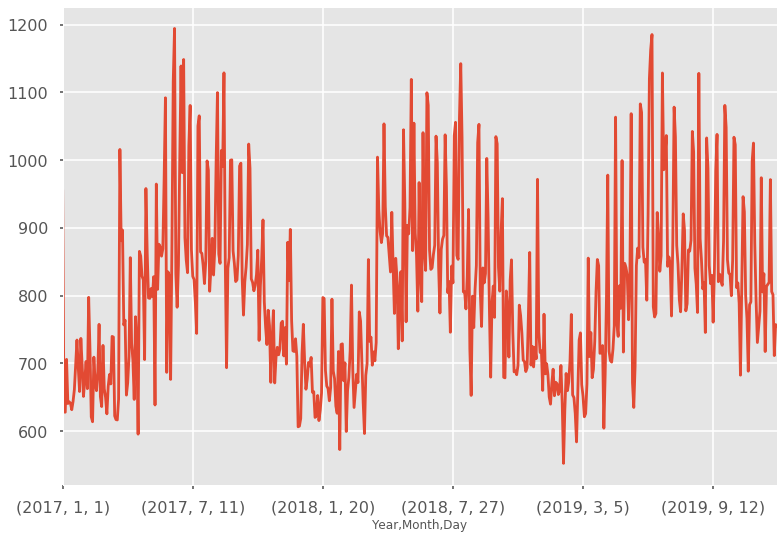

In [65]:
data_grouped_reduced.mean()['TripDuration'].plot()

We do the same with the median 

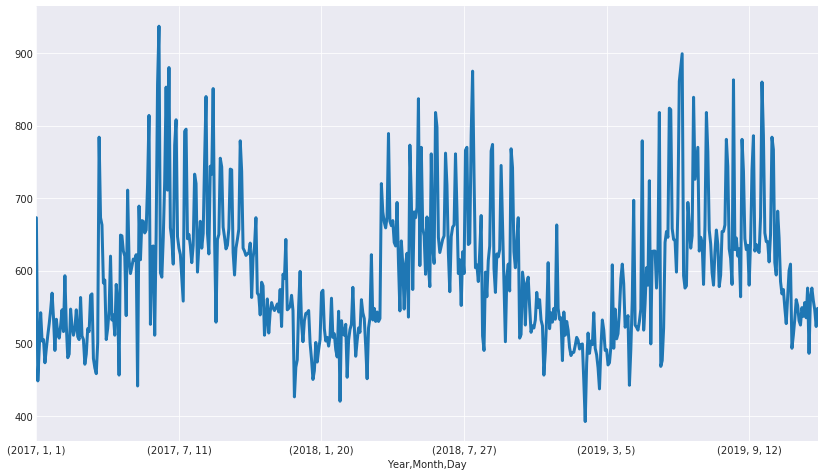

In [22]:
with plt.style.context("seaborn-darkgrid"):
    data_grouped.median()['TripDuration'].plot(figsize=(14,8),linewidth=3)

Let's compare both mileages on one chart

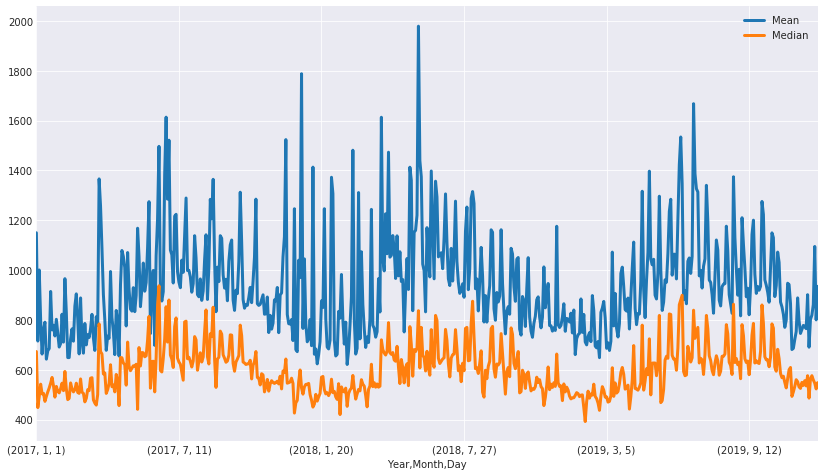

In [24]:
with plt.style.context("seaborn-darkgrid"):
    data_grouped.mean()['TripDuration'].plot(figsize=(14,8),linewidth=3)
    data_grouped.median()['TripDuration'].plot(figsize=(14,8),linewidth=3)
    plt.legend(('Mean','Median'))

The quality conclusions are the same - the highest rate of bike rentals is in the summer and the lowest in the winter. Note that the median is characterized by lower values and lower fluctuations. This is due to the fact that it is less sensitive to outlier observations - most of them have a high value of the examined feature (number of seconds), which automatically increases their average value. 

### Week analysis

Over the last three years, the average time spent travelling by city bicycles has been at a similar level in similar periods (we consider the median here as more representative than the average in the face of a large number of outlier observations). Let us look at how the situation looks like 

In [10]:
data = data.assign(
    WeekDay = data.StartTime.dt.weekday_name
)
data.head()

,TripDuration,StartTime,StopTime,StartStationId,StartStationName,StartStationLatitude,StartStationLongitude,EndStationId,EndStationName,EndStationLatitude,EndStationLongitude,BikeId,UserType,BirthYear,Gender,UserAge,AgeCategory,WeekDay
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226.0,W 82 St & Central Park West,40.782750,-73.971370,3165.0,Central Park West & W 72 St,40.775794,-73.976206,25542,Subscriber,1965.0,2,54.0,U60,Sunday
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263.0,Cooper Square & E 7 St,40.729236,-73.990868,498.0,Broadway & W 32 St,40.748549,-73.988084,21136,Subscriber,1987.0,2,32.0,U40,Sunday
2,648,2017-01-01 00:00:57,2017-01-01 00:11:46,3143.0,5 Ave & E 78 St,40.776829,-73.963888,3152.0,3 Ave & E 71 St,40.768737,-73.961199,18147,Customer,NaN,0,NaN,NaN,Sunday
3,631,2017-01-01 00:01:10,2017-01-01 00:11:42,3143.0,5 Ave & E 78 St,40.776829,-73.963888,3152.0,3 Ave & E 71 St,40.768737,-73.961199,21211,Customer,NaN,0,NaN,NaN,Sunday
4,621,2017-01-01 00:01:25,2017-01-01 00:11:47,3143.0,5 Ave & E 78 St,40.776829,-73.963888,3152.0,3 Ave & E 71 St,40.768737,-73.961199,26819,Customer,NaN,0,NaN,NaN,Sunday


In [12]:
data_weekly_grouped = data.groupby(['WeekDay'])

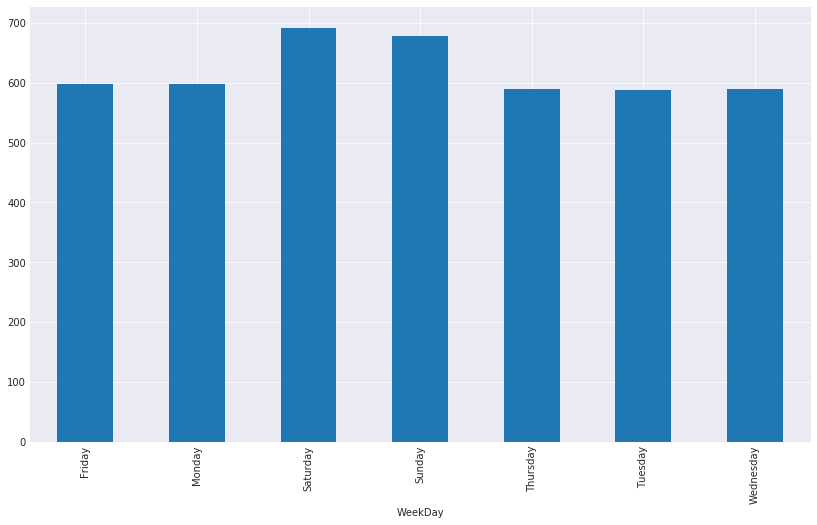

In [13]:
with plt.style.context("seaborn-darkgrid"):
    data_weekly_grouped.median()['TripDuration'].plot(figsize=(14,8), kind='bar')

As expected, the weekend days are the most intense for city bike travel.

Let's take a closer look at the users 

In [12]:
data = data.assign(
    UserAge = 2019-data.BirthYear
)
data.head()

,TripDuration,StartTime,StopTime,StartStationId,StartStationName,StartStationLatitude,StartStationLongitude,EndStationId,EndStationName,EndStationLatitude,EndStationLongitude,BikeId,UserType,BirthYear,Gender,UserAge,AgeCategory
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226.0,W 82 St & Central Park West,40.782750,-73.971370,3165.0,Central Park West & W 72 St,40.775794,-73.976206,25542,Subscriber,1965.0,2,54.0,U60
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263.0,Cooper Square & E 7 St,40.729236,-73.990868,498.0,Broadway & W 32 St,40.748549,-73.988084,21136,Subscriber,1987.0,2,32.0,U40
2,648,2017-01-01 00:00:57,2017-01-01 00:11:46,3143.0,5 Ave & E 78 St,40.776829,-73.963888,3152.0,3 Ave & E 71 St,40.768737,-73.961199,18147,Customer,NaN,0,NaN,NaN
3,631,2017-01-01 00:01:10,2017-01-01 00:11:42,3143.0,5 Ave & E 78 St,40.776829,-73.963888,3152.0,3 Ave & E 71 St,40.768737,-73.961199,21211,Customer,NaN,0,NaN,NaN
4,621,2017-01-01 00:01:25,2017-01-01 00:11:47,3143.0,5 Ave & E 78 St,40.776829,-73.963888,3152.0,3 Ave & E 71 St,40.768737,-73.961199,26819,Customer,NaN,0,NaN,NaN


We will be interested in the impact of age on the lifetime of city bikes. For this purpose, we will divide all users into age groups:
1. 0-10 years: 'U10'
2. 10-20 years: 'U20'
3. 20-30 years: 'U30'

...

10. 90-100 years: 'U100'

In [13]:
data['AgeCategory'] = pd.cut(data.UserAge, np.r_[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
      labels=['U10', 'U20', 'U30', 'U40', 'U50', 'U60', 'U70', 'U80', 'U90', 'U100'])
data.head()

,TripDuration,StartTime,StopTime,StartStationId,StartStationName,StartStationLatitude,StartStationLongitude,EndStationId,EndStationName,EndStationLatitude,EndStationLongitude,BikeId,UserType,BirthYear,Gender,UserAge,AgeCategory
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226.0,W 82 St & Central Park West,40.782750,-73.971370,3165.0,Central Park West & W 72 St,40.775794,-73.976206,25542,Subscriber,1965.0,2,54.0,U60
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263.0,Cooper Square & E 7 St,40.729236,-73.990868,498.0,Broadway & W 32 St,40.748549,-73.988084,21136,Subscriber,1987.0,2,32.0,U40
2,648,2017-01-01 00:00:57,2017-01-01 00:11:46,3143.0,5 Ave & E 78 St,40.776829,-73.963888,3152.0,3 Ave & E 71 St,40.768737,-73.961199,18147,Customer,NaN,0,NaN,NaN
3,631,2017-01-01 00:01:10,2017-01-01 00:11:42,3143.0,5 Ave & E 78 St,40.776829,-73.963888,3152.0,3 Ave & E 71 St,40.768737,-73.961199,21211,Customer,NaN,0,NaN,NaN
4,621,2017-01-01 00:01:25,2017-01-01 00:11:47,3143.0,5 Ave & E 78 St,40.776829,-73.963888,3152.0,3 Ave & E 71 St,40.768737,-73.961199,26819,Customer,NaN,0,NaN,NaN


We can now group users into this category and find out who uses city bikes most often

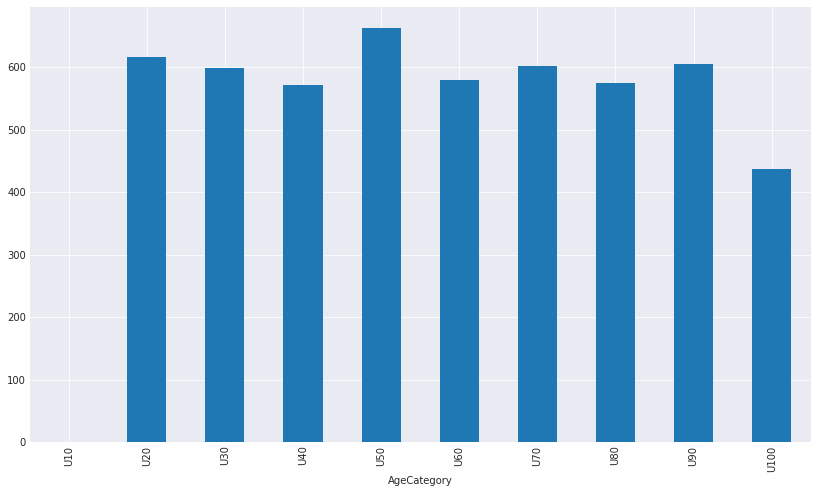

In [8]:
data_age_grouped = data.groupby(['AgeCategory'])
with plt.style.context("seaborn-darkgrid"):
    data_age_grouped.median()['TripDuration'].plot(figsize=(14,8), kind='bar')

Let's see if we can get a similar result by excluding some outlier observations

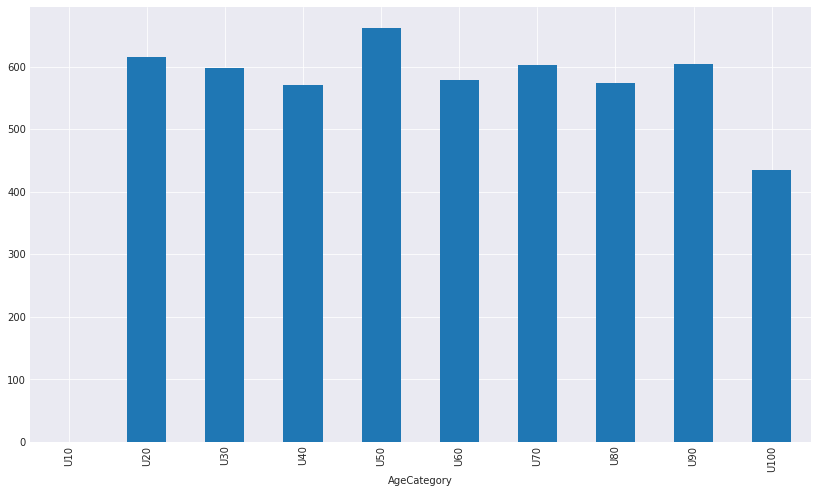

In [9]:
data_reduced = data.loc[data.TripDuration<0.25*10**5]
with plt.style.context("seaborn-darkgrid"):
    data_reduced.groupby('AgeCategory').median()['TripDuration'].plot(figsize=(14,8), kind='bar')

Thus, we can see that the median time of use of bicycles is not dominated by any age group - the distribution of this statistic is similar for all except the elderly (90-100 years).

Another interesting question about users may be about their gender

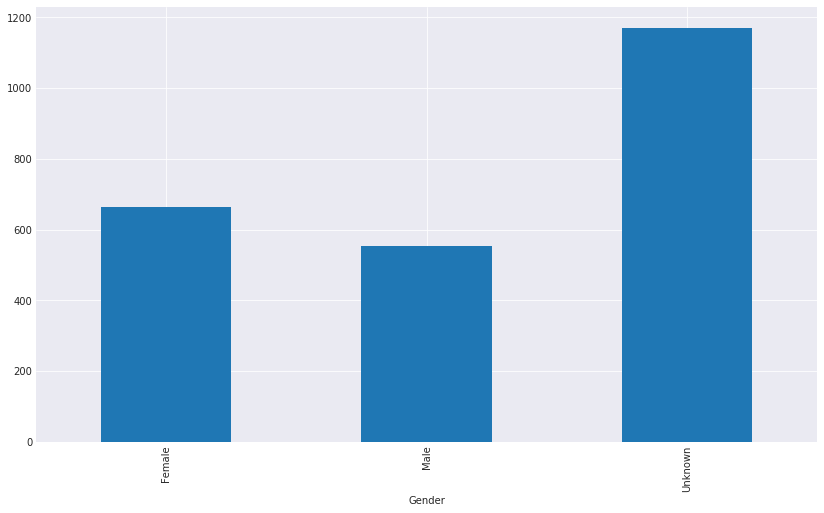

In [25]:
data['Gender'].replace([0,1,2], ['Unknown', 'Male', 'Female'],inplace=True)
data_gender_grouped = data.groupby(['Gender'])
with plt.style.context("seaborn-darkgrid"):
    data_gender_grouped.median()['TripDuration'].plot(figsize=(14,8), kind='bar')

The female gender statistically spends more time on city bikes - more detailed information is obtained by diversifying the population first into age groups and then into gender

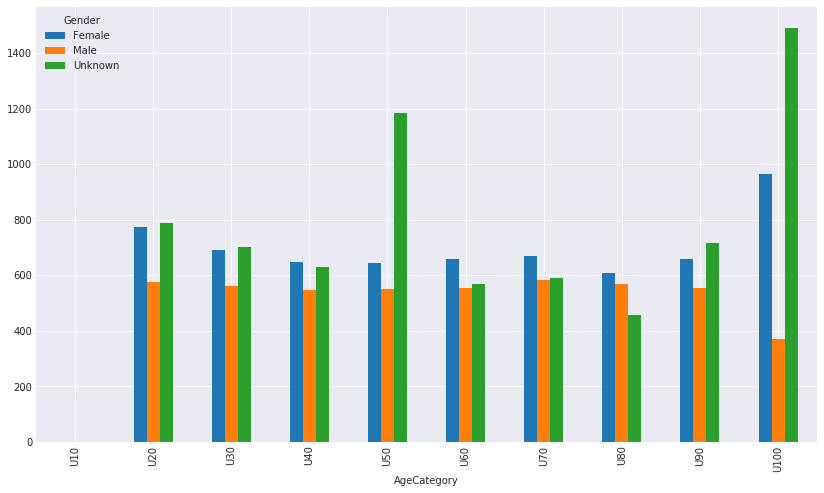

In [41]:
data_age_gender_grouped = data.groupby(['AgeCategory','Gender'])
with plt.style.context("seaborn-darkgrid"):
    data_age_gender_grouped.median()[
        'TripDuration'].reset_index().pivot('AgeCategory','Gender',
                                            'TripDuration').plot(figsize=(14,8), kind='bar')

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np